# Predicting Income Using Neural Networks

### Name: Joseph Willemsz

### Date: May 9, 2022

#### <u>Income Evaluation</u>

https://www.kaggle.com/datasets/lodetomasi1995/income-classification?sort=published

In this lab we're using the income dataset where we want to use the other features to predict whether someone is making over $50,000 per year or not.

**Goal:** Predict income using Neural Networks and at least least two other models.

# Table of Contents
* [Data Preparation & Pre-Processing](#one)
* [Machine Learning Models](#two)
    * [Random Forest](#rf)
    * [XGBoosting](#xgb)
    * [Naive Bayes](#nb)
    * [Neural Network](#nn)
* [Conclusion](#three)

---

# Data Preparation & Pre-Processing <a class="anchor" id="one"></a>

First we import the data as `income_data` and drop the missing values.

In [1]:
import pandas as pd
import numpy as np

income_data = pd.read_csv("Data/income_evaluation.csv").dropna()

Then we clean the variable names using our custom function `clean_names()`

In [2]:
from janitor import clean_names

names = []
for i in range(len(income_data.columns)):
    names.append(clean_names(income_data.columns[i]))

income_data.columns = names

In [3]:
income_data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


We can see that our values for `income` are character strings, but we need to convert them to numeric integer values to run our machine learning models. The `y_full` dataset contains the encoded only the encoded target variable `income`.

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_full = income_data["income"]
y_full = le.fit_transform(y_full)

The dataset `X_full` contains only the predictor varibles, where categorical variables turn into dummy variables. 

In [6]:
X_full = income_data.drop('income', axis='columns')
X_full = pd.get_dummies(X_full)
X_full.columns = X_full.columns.str.replace(' ', '')

Here we standardize the observations in the predictor dataset `X_full`.

In [7]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(X_full)
scaled = scaler.transform(X_full)
X_full = pd.DataFrame(scaled, columns=X_full.columns)

We want to predict `income` in the exercise. However, from the table below we see that the data is imbalanced with 24,720 observations where `income` < \$50,000 and 7,841 observations where `income` > \$50,000.

In [18]:
income_data.income.value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In order to fix this issue of imbalanced data, we implement random oversampling to have an equal number of observations within the two `income` target variable classes.

In [13]:
from imblearn.over_sampling import RandomOverSampler

np.random.seed(0)
ros = RandomOverSampler(sampling_strategy=1) #float

X, y = ros.fit_resample(X_full, y_full)

In [9]:
# from imblearn.under_sampling import RandomUnderSampler

# np.random.seed(0)
# rus = RandomUnderSampler(sampling_strategy='auto') #float

# X, y = rus.fit_resample(X_full, y_full)

Here we split our balanced data into training and testing datasets in order to determine the training and testing accuracies of our models.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [23]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

---

# Machine Learning Models <a class="anchor" id="two"></a>

Here we import the necessary Python functions for our models.

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## <u>Random Forest</u> <a class="anchor" id="rf"></a>

In [13]:
# define search space
params = dict()
params['n_estimators'] = [50, 100, 500, 1000]
params['max_samples'] = np.arange(0.1, 1.1, 0.1)

In [14]:
np.random.seed(0)
rf_model = RandomForestClassifier()
grid_rf = GridSearchCV(estimator = rf_model,
                  param_grid = params,
                  scoring = 'accuracy',
                  cv = [(slice(None), slice(None))],
                  verbose = 1)

In [15]:
%%time
np.random.seed(0)
grid_rf.fit(X_train, y_train)

Fitting 1 folds for each of 40 candidates, totalling 40 fits
Wall time: 11min 28s


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid={'max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'n_estimators': [50, 100, 500, 1000]},
             scoring='accuracy', verbose=1)

In [16]:
print('Optimal Model:', grid_rf.best_estimator_)
print('Training accuracy:', round(grid_rf.best_score_*100, 4), "%")

rf = grid_rf.best_estimator_
np.random.seed(0)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_hat)*100
print('Testing accuracy:', round(rf_accuracy, 4), '%')

Optimal Model: RandomForestClassifier(max_samples=0.8, n_estimators=1000)
Training accuracy: 99.9975 %
Testing accuracy: 92.9409 %


Our optimal Random Forest model had a training accuracy of 92% with the following hyperparameters:
- `max_samples` = 0.8
- `n_estimators` = 1000

In [7]:
top_models = dict()
top_models['random_forest'] = rf_accuracy

## <u>XGBoosting</u> <a class="anchor" id="xgb"></a>

In [18]:
params = dict()
params['n_estimators'] = [50, 100, 500, 1000]
params['learning_rate'] = np.arange(0.1, 1.1, 0.1).round(1)

In [19]:
np.random.seed(0)
xgb_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=0)
grid_xgb = GridSearchCV(estimator = xgb_model,
                  param_grid = params,
                  scoring = 'accuracy',
                  cv = [(slice(None), slice(None))],
                  verbose = 1)

In [20]:
np.random.seed(0)
grid_xgb.fit(X_train, y_train)

Fitting 1 folds for each of 40 candidates, totalling 40 fits


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_de...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None, scale_pos_wei

In [21]:
print('Best hyperparameters:', grid_xgb.best_params_)
print('Training accuracy:', round(grid_xgb.best_score_, 4)*100, '%')

xgb = grid_xgb.best_estimator_
np.random.seed(0)
xgb.fit(X_train, y_train)
y_hat = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_hat)*100
print('Testing accuracy:', round(xgb_accuracy, 4), '%')

Best hyperparameters: {'learning_rate': 0.7, 'n_estimators': 1000}
Training accuracy: 100.0 %
Testing accuracy: 93.1837 %


Our optimal XGBoosting model had a training accuracy of 93% with the following hyperparameters:
- `learning_rate` = 0.7
- `n_estimators` = 1000

In [22]:
top_models['xgboosting'] = xgb_accuracy

## <u>Naive Bayes</u> <a class="anchor" id="nb"></a>

In [3]:
# define search space
params = dict()
params['var_smoothing'] = [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]

In [4]:
nb_model = GaussianNB()

In [5]:
np.random.seed(0)
grid_nb = GridSearchCV(estimator = nb_model,
                  param_grid = params,
                  scoring = 'accuracy',
                  cv = [(slice(None), slice(None))],
                  verbose = 1)

In [6]:
%%time
np.random.seed(0)
grid_nb.fit(X_train, y_train)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Wall time: 3.29 s


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06,
                                           1e-05, 0.0001, 0.001, 0.01, 0.1]},
             scoring='accuracy', verbose=1)

In [7]:
print('Best hyperparameters:', grid_nb.best_params_)
print('Training accuracy:', round(grid_nb.best_score_, 4)*100, '%')

nb = grid_nb.best_estimator_
np.random.seed(0)
nb.fit(X_train, y_train)
nb_accuracy = nb.score(X_test, y_test)*100
print('Testing accuracy:', round(nb_accuracy, 4), '%')

Best hyperparameters: {'var_smoothing': 0.1}
Training accuracy: 78.64 %
Testing accuracy: 79.1768 %


Our optimal Naive Bayes model had a training accuracy of 79% with the following hyperparameters:
- `var_smoothing` = 0.1

In [8]:
top_models["naive_bayes"] = nb_accuracy

## <u>Neural Network</u> <a class="anchor" id="nn"></a>

In [23]:
params = dict()
params['activation'] = ['identity', 'logistic', 'tanh', 'relu']
params['hidden_layer_sizes'] = np.arange(5, 105, 5)
params['learning_rate_init'] = [0.001, 0.01, 0.1, 1]
#params['max_iter'] = [100, 200, 300, 400, 500]

In [24]:
np.random.seed(0)
grid_nn = GridSearchCV(estimator = MLPClassifier(random_state=0),
                  param_grid = params,
                  scoring = 'accuracy',
                  cv = [(slice(None), slice(None))],
                  verbose = 1)

In [25]:
%%time
np.random.seed(0)
grid_nn.fit(X_train, y_train)

Fitting 1 folds for each of 320 candidates, totalling 320 fits
Wall time: 1h 36min 44s


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=MLPClassifier(random_state=0),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100]),
                         'learning_rate_init': [0.001, 0.01, 0.1, 1]},
             scoring='accuracy', verbose=1)

In [26]:
print('Best hyperparameters:', grid_nn.best_params_)
print('Training accuracy:', round(grid_nn.best_score_*100, 4))

nn = grid_nn.best_estimator_
np.random.seed(0)
nn.fit(X_train, y_train)
nn_accuracy = nn.score(X_test, y_test)*100
print('Testing accuracy:', round(nn_accuracy, 4))

Best hyperparameters: {'activation': 'logistic', 'hidden_layer_sizes': 90, 'learning_rate_init': 0.01}
Training accuracy: 90.1446
Testing accuracy: 87.1764


Our optimal Neural Network model with a single hidden layer had a training accuracy of 92% with the following hyperparameters:
- `activation` = logistic
- `hidden_layer_sizes` = 90
- `learning_rate_init` = 0.01

In [27]:
top_models["neural_network"] = nn_accuracy

---

# Conclusion <a class="anchor" id="three"></a>

Sort models in dictionary from smallest to largest accuracies.

In [2]:
top_models = dict(sorted(top_models.items(),key= lambda x:x[1]))

[Text(0.5, 1.0, 'Model Accuracy'), Text(0, 0.5, 'Training accuracy (in %)')]

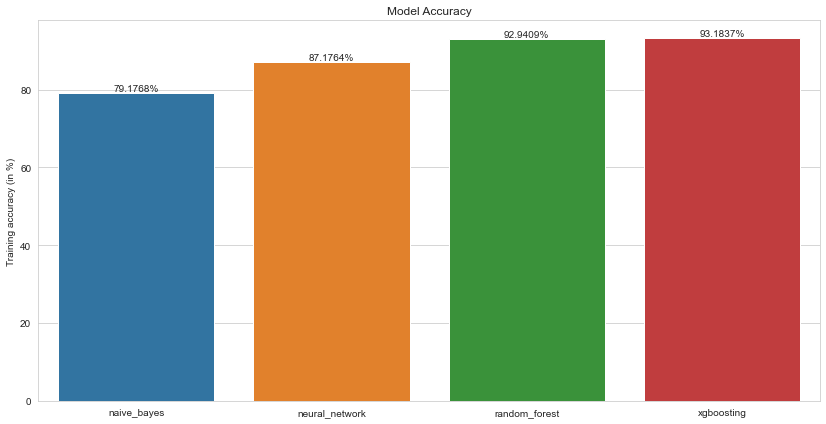

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

keys = list(top_models.keys())
# get values in the same order as keys, and parse percentage values
vals = list(top_models.values())
ax = sns.barplot(x=keys, y=vals)

# set background theme
sns.set_style("whitegrid")

ax.bar_label(ax.containers[0], label_type='edge', fmt='%.4f%%')
ax.set(title='Model Accuracy', ylabel="Training accuracy (in %)")

From the plot above we can see that the **XGBoosting model** performed the best in predicting whether a person is making over \$50,000 a year or not, with a training accuracy of 93%.

Followed by the Random Forest, Neural Network, and Naive Bayes models.

### Save & Load Workspace

In [11]:
# import dill
# dill.dump_session('lab5_env.db')

In [1]:
import dill
dill.load_session('lab5_env.db')